In [1]:
import sgkit as sg
import admixcov as ac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ds = sg.load_dataset("../../results/Patterson2022_filtered.zarr")
ds

<xarray.Dataset>
Dimensions:                    (variants: 474554, samples: 585, ploidy: 1,
                                cohorts: 7, cohorts_ref: 3, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, cohorts,
                                cohorts_ref, alleles
Data variables: (12/27)
    call_genotype              (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 585, 1), meta=np.ndarray>
    call_genotype_mask         (variants, samples, ploidy) bool dask.array<chunksize=(10000, 585, 1), meta=np.ndarray>
    cohorts_id                 (cohorts) <U24 dask.array<chunksize=(7,), meta=np.ndarray>
    cohorts_ref_id             (cohorts_ref) <U9 dask.array<chunksize=(3,), meta=np.ndarray>
    mask_cohorts               (cohorts, samples) bool dask.array<chunksize=(7, 585), meta=np.ndarray>
    mask_cohorts_ref           (cohorts_ref, samples) bool dask.array<chunksize=(3, 585), meta=np.ndarray>
    ...                         ...
    variant_contig             (variants) int16 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_count_nonmiss      (cohorts, variants) int64 dask.array<chunksize=(7, 10000), meta=np.ndarray>
    variant_count_nonmiss_ref  (cohorts_ref, variants) int64 dask.array<chunksize=(3, 10000), meta=np.ndarray>
    variant_id                 (variants) <U16 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position           (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_rate               (variants) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',...
    source:   sgkit-0.5.0

In [3]:
geno = ds.call_genotype.values[:,:,0].T.astype(float)
geno[geno == -1] = np.nan
print(geno.shape)

rf = np.stack([np.nanmean(geno[mask], axis=0) for mask in ds.mask_cohorts_ref.values])
sample_size_ref = [np.sum(mask) for mask in ds.mask_cohorts_ref.values]
print(sample_size_ref)

(585, 474554)
[18, 21, 18]


In [4]:
def allele_freq(geno, mask):
	return np.nanmean(geno[mask], axis=0)

af = np.stack([
	allele_freq(geno, mask)
	for mask in ds.mask_cohorts.values
])

sample_size = np.array([
	np.sum(mask)
	for mask in ds.mask_cohorts.values
])
print(sample_size)

[ 37  69  26  23 273  38  62]


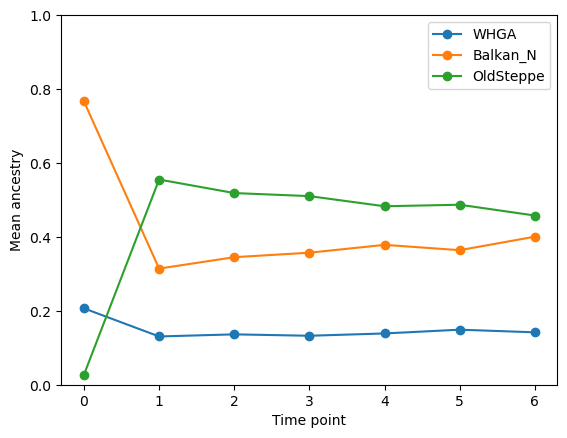

In [5]:
Q = admix = np.stack([
	np.mean(ds.sample_admixture[mask], axis=0)
	for mask in ds.mask_cohorts.values
])
fig, ax = plt.subplots()
for i, pop in enumerate(ds.cohorts_ref_id.values):
	ax.plot(Q[:,i], '-o', label=pop)
_ = ax.set_ylim((0,1))
_ = ax.set_ylabel("Mean ancestry")
_ = ax.set_xlabel("Time point")
plt.legend(loc="upper right")

In [6]:
covmat = ac.get_covariance_matrix(
	af,
	bias=True,
	sample_size=ds.variant_count_nonmiss.values,
)
admix_cov = ac.get_admix_covariance_matrix(
	Q,
	ref_af=rf,
	bias=True,
	ref_sample_size=ds.variant_count_nonmiss_ref.values,
)


In [7]:
alpha_mask = np.array([
	[0, 0, 1],
	[0, 1, 0],
	[0, 1, 0],
	[0, 1, 0],
	[1, 0, 0],
	[0, 1, 0],
], dtype=bool) # says which alpha is different from zero
alphas = ac.q2a_simple(Q, alpha_mask)
var_drift = ac.solve_for_variances(
	np.diag(covmat - admix_cov),
	alphas,
)
drift_err = ac.get_drift_err_matrix(var_drift, alphas)

In [8]:
print(alphas)

[[0.         0.         0.54282814]
 [0.         0.04501918 0.        ]
 [0.         0.01853724 0.        ]
 [0.         0.0329648  0.        ]
 [0.01185482 0.         0.        ]
 [0.         0.05733729 0.        ]]


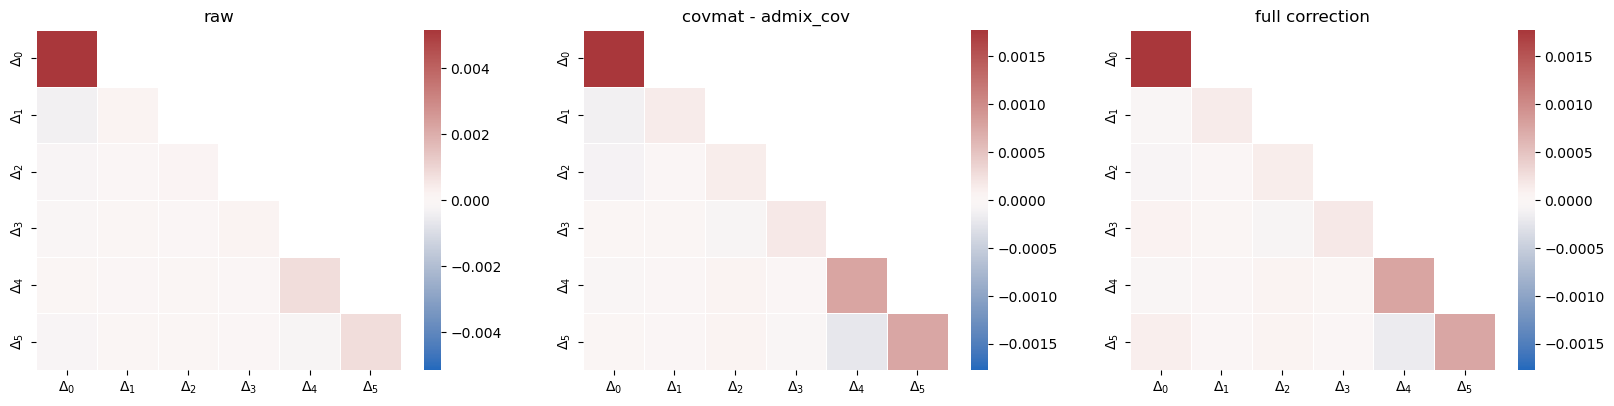

In [9]:
ac.plot_covmats(
	[
		covmat,
		covmat - admix_cov,
		covmat - admix_cov - drift_err,
	],
	list_titles=[
		'raw',
		'covmat - admix_cov',
		'full correction',
	],
	mask_diag=False,
	# mask_diag=True,
)
fig.show()

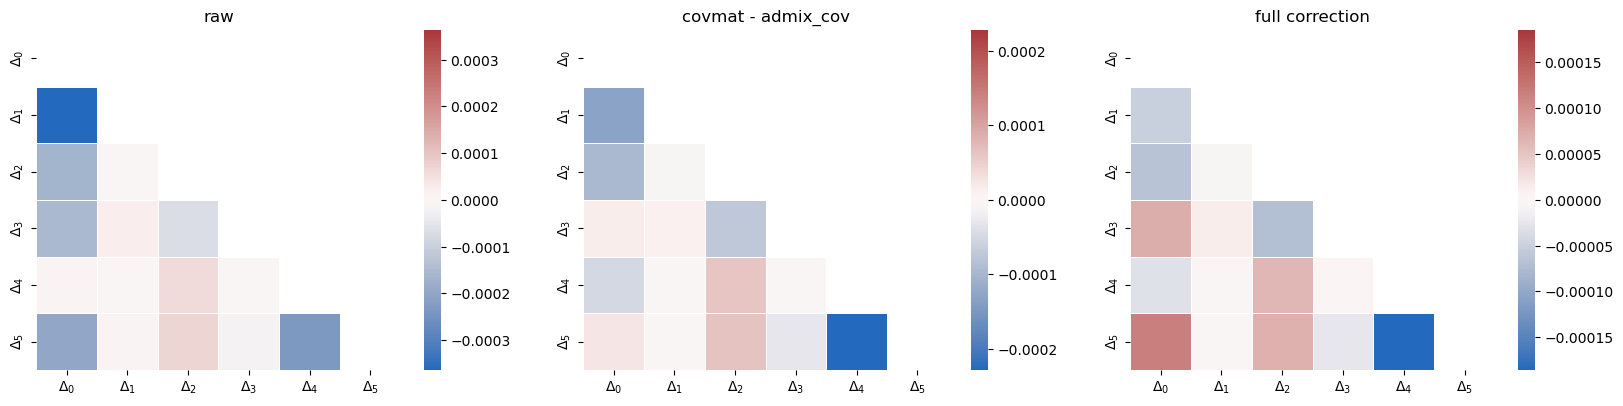

In [10]:
ac.plot_covmats(
	[
		covmat,
		covmat - admix_cov,
		covmat - admix_cov - drift_err,
	],
	list_titles=[
		'raw',
		'covmat - admix_cov',
		'full correction',
	],
	# mask_diag=False,
	mask_diag=True,
)
fig.show()

In [19]:
print(ac.get_G(covmat - admix_cov - drift_err, af, sample_size, abs=False))
print(ac.get_G(covmat - admix_cov - drift_err, af, sample_size, abs=True))

-0.03200132763962124
0.2295163376511303


In [12]:
tile_idxs = ac.sg.create_tile_idxs(ds, type='position', size=5e6)
sizes = [x.size for x in tile_idxs]
print(np.mean(sizes))
print(np.min(sizes))
print(np.max(sizes))
print(len(tile_idxs))

841.4078014184397
1
3340
564


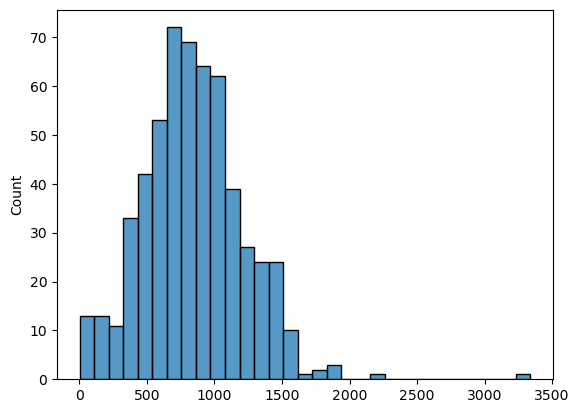

In [21]:
_ = sns.histplot(sizes)

In [14]:
straps_cov, straps_admix_cov, straps_corr_cov, straps_G, straps_Ap = ac.bootstrap(
	tile_idxs, af, ds.variant_count_nonmiss.values,
	Q, rf, ds.variant_count_nonmiss_ref.values, alphas,
	N_bootstrap=1e4,
	bias=True, drift_err=True,
	# abs_G=True,
)

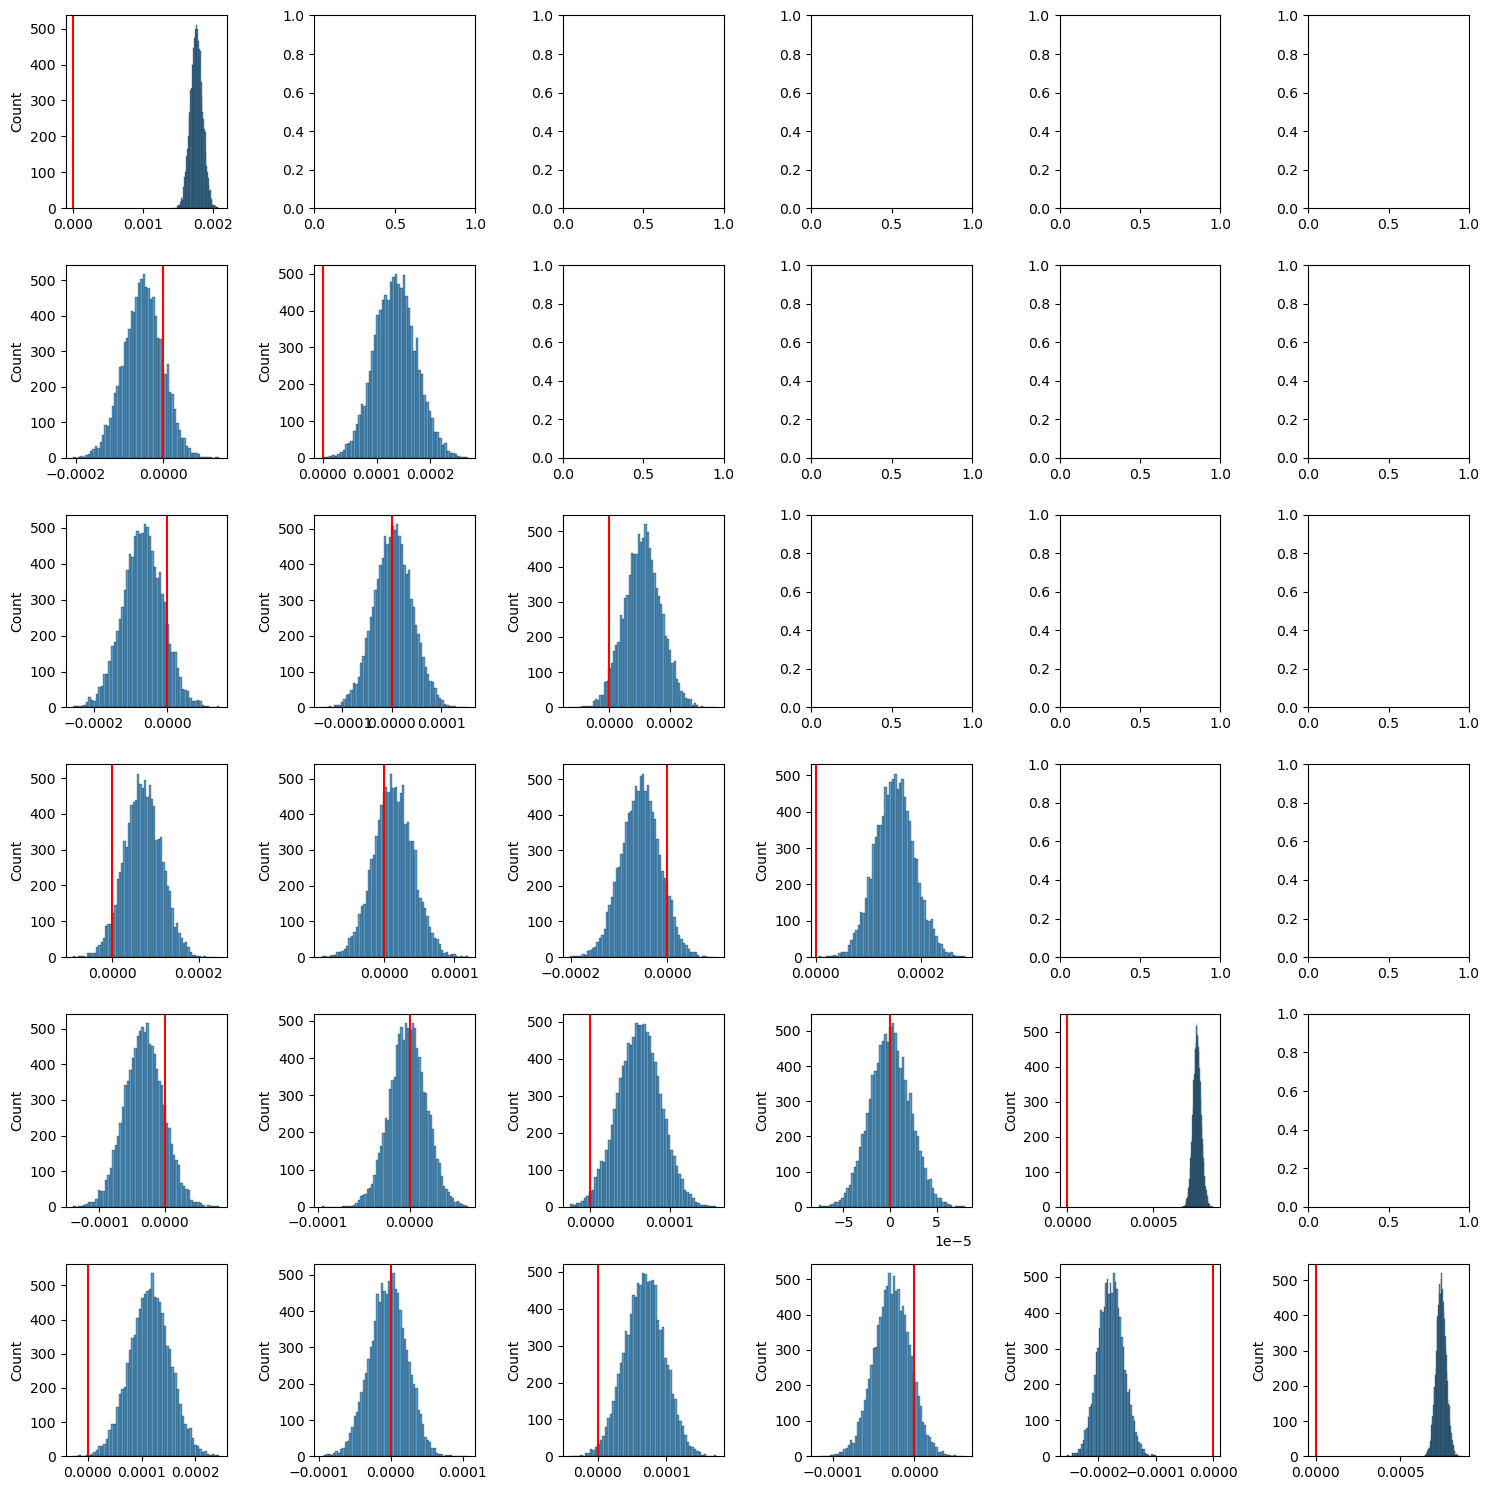

In [15]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
	for j in range(i+1):
		_ = sns.histplot(straps_corr_cov[:, i, j], ax=axs[i, j])
		axs[i, j].axvline(0, color='red')
fig.tight_layout()

In [19]:
sig_alpha = 0.05/21
quants = np.quantile(straps_corr_cov, q=[sig_alpha / 2, (1 - sig_alpha / 2)], axis=0)
(quants[0] * quants[1]) > 0

array([[ True, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True]])

[-0.07708715  0.01424285]


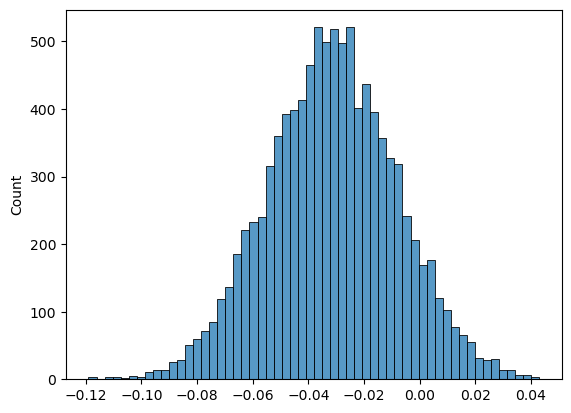

In [20]:
sns.histplot(straps_G)
print(np.quantile(straps_G, q=[0.025, 0.975]))

[0.67299165 0.72230368]


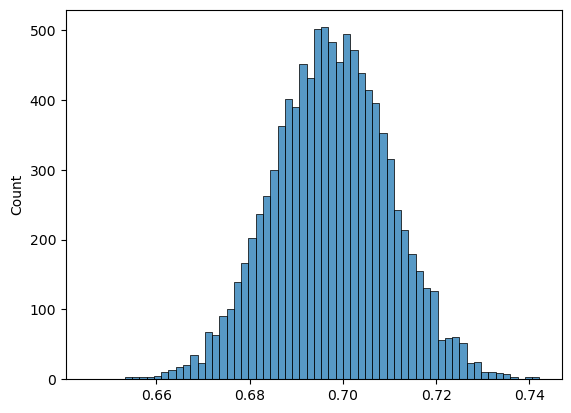

In [21]:
sns.histplot(straps_Ap)
print(np.quantile(straps_Ap, q=[0.025, 0.975]))